In [23]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import string 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import tensorflow as tf 
from tensorflow import keras
import warnings
from sklearn.model_selection import train_test_split

In [6]:
warnings.filterwarnings("ignore")

In [7]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
df = pd.read_csv("emails.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [9]:
df.shape

(5728, 2)

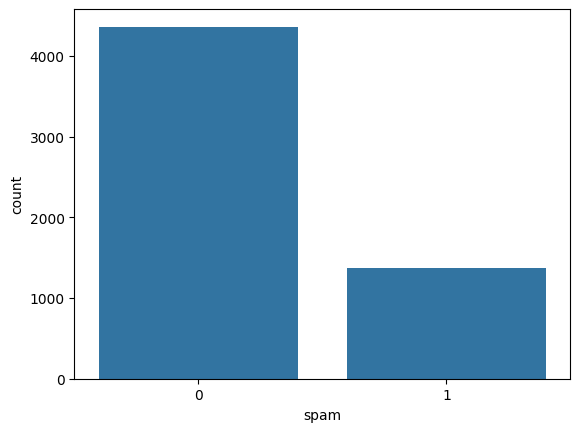

In [11]:
sns.countplot(x="spam", data=df)
plt.show()

In [13]:
ham_msg = df[df["spam"] == 0]
spam_msg = df[df["spam"] == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)
print(len(ham_msg), len(spam_msg), sep="\n")

1368
1368


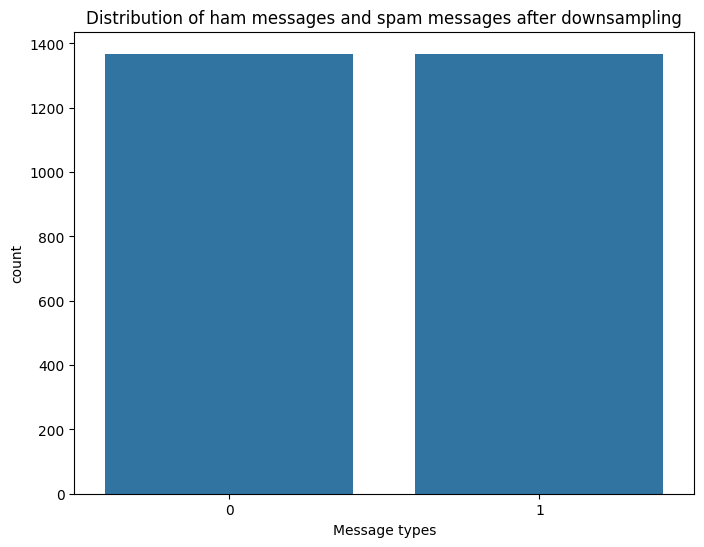

In [14]:
balanced_data = ham_msg.append(spam_msg).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(x="spam", data=balanced_data)
plt.title("Distribution of ham messages and spam messages after downsampling")
plt.xlabel("Message types")
plt.show()

In [15]:
balanced_data["text"] = balanced_data["text"].str.replace("Subject", "")
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [16]:
punctuations_list = string.punctuation 
def remove_punctuations(text):
    output = str.maketrans("", "", punctuations_list)
    return text.translate(output)

In [17]:
balanced_data["text"] = balanced_data["text"].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [18]:
def remove_stopwords(text):
    stop_words = stopwords.words("english")
    imp_words = []
    for word in str(text).split():
        word = word.lower()
        if not word in stop_words:
            imp_words.append(word)
    
    output = " ".join(imp_words)
    return output

In [19]:
balanced_data["text"] = balanced_data["text"].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


In [20]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data["text"])
    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color="black", 
                   max_words=100, height=400, width=800, 
                   collocations=False).generate(email_corpus)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {typ} emails", fontsize=15)
    plt.show()

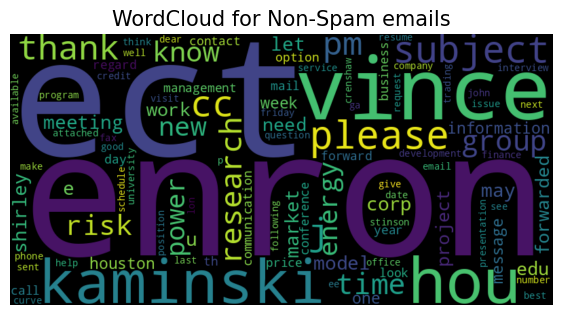

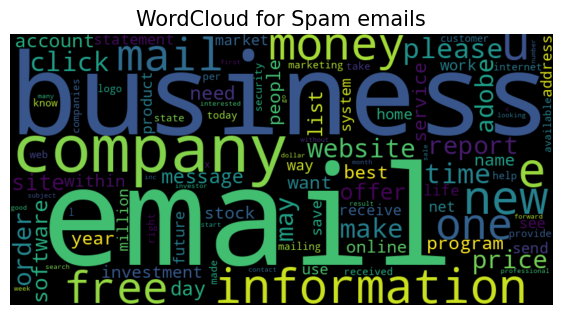

In [22]:
plot_word_cloud(balanced_data[balanced_data["spam"] == 0], typ="Non-Spam")
plot_word_cloud(balanced_data[balanced_data["spam"] == 1], typ="Spam")

In [24]:
X = balanced_data["text"]
Y = balanced_data["spam"]
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [25]:
# tokenize the text data
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x_train)

# convert text to sequence
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# pad sequences
max_len = 100
train_sequences = keras.preprocessing.sequence.pad_sequences(
    train_sequences, maxlen=max_len, padding="post", truncating="post"
)
test_sequences = keras.preprocessing.sequence.pad_sequences(
    test_sequences, maxlen=max_len, padding="post", truncating="post"
)

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                                 output_dim=32, input_length=max_len))
model.add(keras.layers.LSTM(units=16))
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(keras.layers.Dense(units=1, activation="sigmoid"))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808,737
Trainable params: 808,737
Non-trainable params: 0
_________________________________________________________________


In [28]:
len(tokenizer.word_index)

25156

In [29]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [32]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                  monitor="val_accuracy",
                                                  restore_best_weights=True)
reduce_lr_on_plateu_cb = keras.callbacks.ReduceLROnPlateau(patience=2,
                                                    monitor="val_loss", 
                                                    factor=0.5, verbose=0)
callbacks = [early_stopping_cb, reduce_lr_on_plateu_cb]

In [33]:
history = model.fit(train_sequences, y_train,
                    validation_data=(test_sequences, y_test),
                    epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
69/69 [==============================] - 11s 86ms/step - loss: 0.5769 - accuracy: 0.7390 - val_loss: 0.2715 - val_accuracy: 0.9434 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - 5s 73ms/step - loss: 0.2378 - accuracy: 0.9337 - val_loss: 0.1925 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - 8s 121ms/step - loss: 0.1640 - accuracy: 0.9561 - val_loss: 0.1933 - val_accuracy: 0.9434 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - 8s 115ms/step - loss: 0.1316 - accuracy: 0.9676 - val_loss: 0.1939 - val_accuracy: 0.9489 - lr: 0.0010
Epoch 5/10
69/69 [==============================] - 8s 110ms/step - loss: 0.0936 - accuracy: 0.9790 - val_loss: 0.1810 - val_accuracy: 0.9544 - lr: 5.0000e-04
Epoch 6/10
69/69 [==============================] - 6s 88ms/step - loss: 0.0850 - accuracy: 0.9813 - val_loss: 0.1873 - val_accuracy: 0.9580 - lr: 5.0000e-04
Epoch 7/10
69/69 [==============================] - 6s 80ms/step

In [35]:
round(len(train_sequences)/32) + 1

69

In [38]:
test_loss, test_acc = model.evaluate(test_sequences, y_test)
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

18/18 [==============================] - 0s 16ms/step - loss: 0.1280 - accuracy: 0.9745
Test loss: 0.128
Test accuracy: 0.974


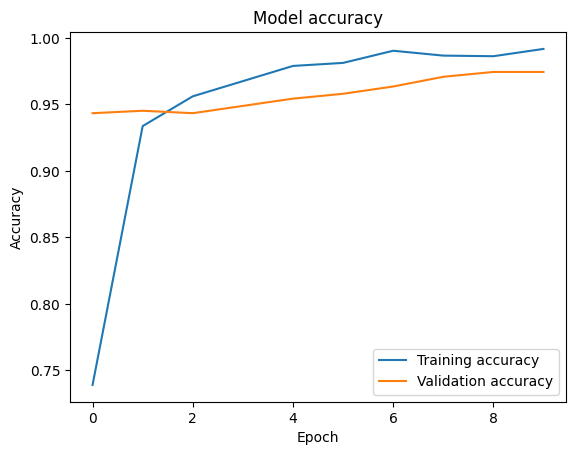

In [39]:
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
y_pred = model.predict(test_sequences)
print(y_pred)

18/18 [==============================] - 1s 19ms/step
[[2.3753785e-03]
 [9.8260385e-01]
 [1.6050129e-03]
 [9.8253793e-01]
 [2.3955889e-03]
 [2.3956946e-03]
 [2.4069704e-03]
 [9.8258662e-01]
 [2.3828866e-03]
 [9.8260623e-01]
 [9.7754508e-01]
 [9.8260516e-01]
 [1.6456899e-03]
 [2.3955556e-03]
 [1.4707190e-03]
 [7.9034752e-04]
 [2.3864270e-03]
 [9.8260731e-01]
 [1.9547143e-03]
 [9.8260641e-01]
 [2.4005475e-03]
 [2.6436108e-03]
 [2.4011538e-03]
 [2.3894906e-03]
 [2.9170781e-03]
 [9.8260725e-01]
 [9.8260659e-01]
 [9.8250002e-01]
 [2.3984690e-03]
 [2.3960411e-03]
 [2.1410517e-03]
 [2.0345098e-03]
 [9.8260319e-01]
 [3.7239373e-03]
 [2.3893614e-03]
 [2.4159567e-03]
 [1.1557136e-03]
 [9.8151851e-01]
 [9.7893631e-01]
 [1.4370841e-03]
 [9.7759181e-01]
 [9.7825551e-01]
 [2.1554129e-03]
 [1.0484334e-03]
 [2.7534619e-02]
 [1.7771113e-03]
 [2.3818815e-03]
 [1.3842032e-03]
 [9.8256874e-01]
 [9.8214680e-01]
 [1.9652506e-03]
 [9.8260719e-01]
 [2.3966192e-03]
 [9.8260719e-01]
 [9.8260427e-01]
 [9.8260683

In [51]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = keras.preprocessing.sequence.pad_sequences(new_seq,
        maxlen=max_len, padding="post", truncating="post")
    y_pred = model.predict(padded)
    for pred in y_pred:
        if pred > 0.5:
            print("Spam")
        else:
            print("Non-Spam")

In [52]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

predict_spam(predict_msg)

1/1 [==============================] - 0s 69ms/step
Spam
Non-Spam
Spam
